
--- Rozpoczynanie symulacji dla Q = -1 ---
Iteracja: 1000, Zmiana: 2.81e-06

--- Rozpoczynanie symulacji dla Q = -10 ---
Iteracja: 1000, Zmiana: 4.30e-05
Iteracja: 2000, Zmiana: 1.55e-05

--- Rozpoczynanie symulacji dla Q = -100 ---
Iteracja: 1000, Zmiana: 1.33e-03
Iteracja: 2000, Zmiana: 4.08e-04

--- Rozpoczynanie symulacji dla Q = -200 ---
Iteracja: 1000, Zmiana: 3.79e-04

--- Rozpoczynanie symulacji dla Q = -400 ---
Iteracja: 1000, Zmiana: 1.66e-03


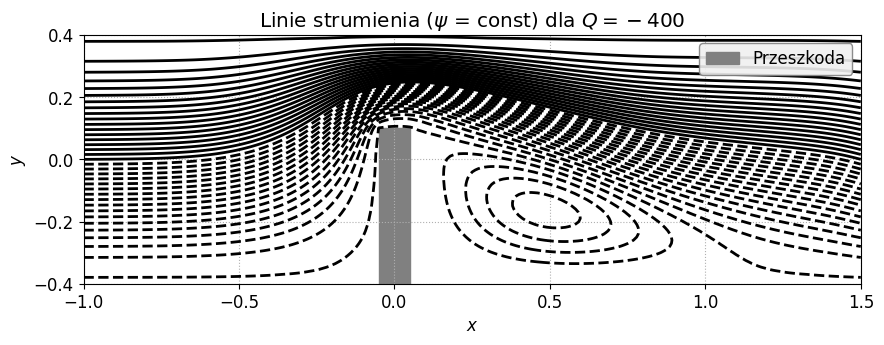

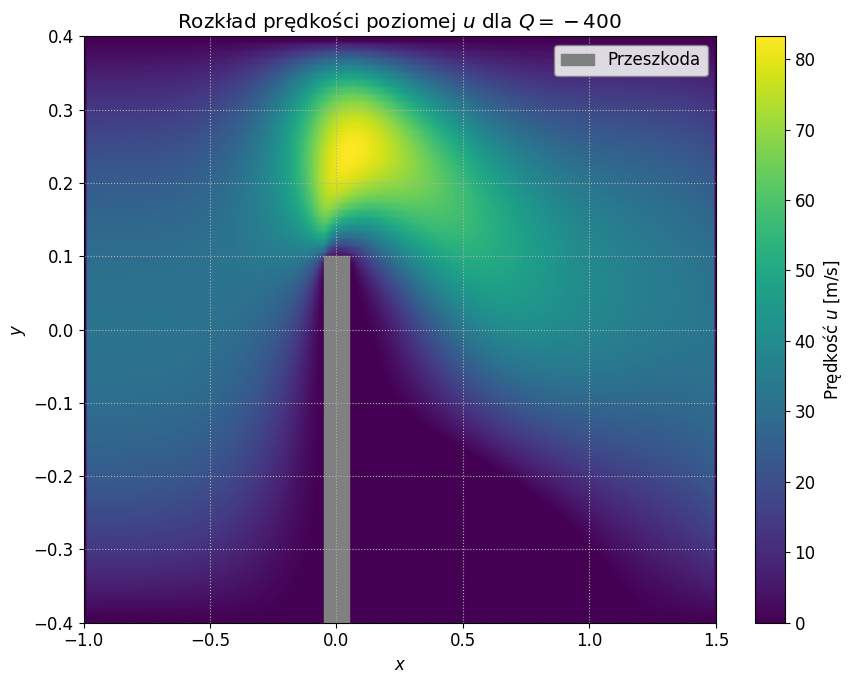

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry
nx, ny = 251, 81
a, b = 100, 40
dz = 0.01
mu, rho = 1.0, 1.0
Q_values = [-1, -10, -100, -200, -400]
ik, jk = 5, 10
y1, y2 = -40 * dz, 40 * dz
max_iter, eps, min_iter = 30000, 1e-6, 500
imin_obs, imax_obs, jmax_obs = -ik + a, ik + a, jk + b

# Maska logiczna do pomijania zastawki
is_fluid = np.full((nx, ny), True, dtype=bool)
is_fluid[imin_obs:imax_obs+1, :jmax_obs+1] = False
is_fluid_interior = is_fluid[1:-1, 1:-1]

# Funkcje analityczne
def psi_analytic(y, q_val): return (q_val / (2 * mu)) * (y**3 / 3 + y1 * y2 * y)
def dze_analytic(y, q_val): return (q_val / mu) * y

# Pętla po Q
for Q in Q_values:
    print(f"\n--- Rozpoczynanie symulacji dla Q = {Q} ---")

    psi = np.zeros((nx, ny))
    dze = np.zeros((nx, ny))
    y_vec = (np.arange(ny) - b) * dz
    for i in range(nx):
        psi[i, :] = psi_analytic(y_vec, Q)
        dze[i, :] = dze_analytic(y_vec, Q)
    psi_bottom_val = psi_analytic(y1, Q)

    for iteration in range(max_iter):
        psi_prev = psi[50 + a, 20 + b]

        # Aktualizacja warunków brzegowych
        psi[:, 0] = psi_bottom_val
        psi[imin_obs:imax_obs + 1, :jmax_obs + 1] = psi_bottom_val
        dze[:, ny-1] = 2 * (psi[:, ny-2] - psi[:, ny-1]) / dz**2
        dze[imax_obs+1:, 0] = 2 * (psi[imax_obs+1:, 1] - psi[imax_obs+1:, 0]) / dz**2
        dze[:imin_obs, 0] = 2 * (psi[:imin_obs, 1] - psi[:imin_obs, 0]) / dz**2
        dze[imin_obs, :jmax_obs+1] = 2 * (psi[imin_obs-1, :jmax_obs+1] - psi[imin_obs, :jmax_obs+1]) / dz**2
        dze[imax_obs, :jmax_obs+1] = 2 * (psi[imax_obs+1, :jmax_obs+1] - psi[imax_obs, :jmax_obs+1]) / dz**2
        dze[imin_obs:imax_obs+1, jmax_obs] = 2 * (psi[imin_obs:imax_obs+1, jmax_obs+1] - psi[imin_obs:imax_obs+1, jmax_obs]) / dz**2

        psi_new = psi.copy()
        dze_new = dze.copy()

        psi_update = 0.25 * (psi[2:, 1:-1] + psi[:-2, 1:-1] + psi[1:-1, 2:] + psi[1:-1, :-2] - dze[1:-1, 1:-1] * dz**2)
        term_psi_y = psi[1:-1, 2:] - psi[1:-1, :-2]
        term_dze_x = dze[2:, 1:-1] - dze[:-2, 1:-1]
        term_psi_x = psi[2:, 1:-1] - psi[:-2, 1:-1]
        term_dze_y = dze[1:-1, 2:] - dze[1:-1, :-2]
        dze_update = 0.25 * (dze[2:, 1:-1] + dze[:-2, 1:-1] + dze[1:-1, 2:] + dze[1:-1, :-2]) - (rho / (16 * mu)) * (term_psi_y * term_dze_x - term_psi_x * term_dze_y)

        psi_new[1:-1, 1:-1][is_fluid_interior] = psi_update[is_fluid_interior]
        dze_new[1:-1, 1:-1][is_fluid_interior] = dze_update[is_fluid_interior]

        psi, dze = psi_new, dze_new

        if iteration > min_iter:
            delta = abs(psi[50 + a, 20 + b] - psi_prev)
            if iteration % 1000 == 0:
                print(f"Iteracja: {iteration}, Zmiana: {delta:.2e}")
            if delta < eps and iteration > 1000:
                break

    # Obliczenie pól prędkości
    u = np.zeros_like(psi)
    v = np.zeros_like(psi)
    u[1:-1, 1:-1] = (psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * dz)
    v[1:-1, 1:-1] = -(psi[2:, 1:-1] - psi[:-2, 1:-1]) / (2 * dz)
    x_coords = (np.arange(nx) - a) * dz
    y_coords = (np.arange(ny) - b) * dz

    # Wykresy
    plt.rcParams.update({
        'lines.linewidth': 2,
        'font.size': 12,
        'legend.framealpha': 0.9,
        'legend.facecolor': '#f0f0f0',
        'legend.edgecolor': 'gray'
    })

  # Styl globalny
plt.rcParams.update({
    'lines.linewidth': 2,
    'font.size': 12,
    'legend.framealpha': 0.9,
    'legend.facecolor': '#f0f0f0',
    'legend.edgecolor': 'gray'
})

# Wykres 1: Linie strumienia
plt.figure(figsize=(9, 7))
ax1 = plt.gca()
ax1.contour(x_coords, y_coords, psi.T, levels=40, colors='k', linewidths=2)
ax1.fill_between(x_coords[imin_obs:imax_obs+1], y1, y_coords[jmax_obs], color='gray', label='Przeszkoda')
ax1.set_title(f'Linie strumienia ($\psi$ = const) dla $Q = {Q}$')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_aspect('equal', adjustable='box')
ax1.grid(True, linestyle=':', linewidth=0.8)
ax1.legend(loc='best')
plt.tight_layout()
plt.show()

# Wykres 2: Prędkość pozioma u
plt.figure(figsize=(9, 7))
ax2 = plt.gca()
vmax_u = np.max(np.abs(u))
im_u = ax2.imshow(u.T, origin='lower', aspect='auto', cmap='viridis',
                  extent=[x_coords[0], x_coords[-1], y1, y2],
                  vmin=0, vmax=vmax_u)
ax2.fill_between(x_coords[imin_obs:imax_obs+1], y1, y_coords[jmax_obs], color='gray', label='Przeszkoda')
ax2.set_title(f'Rozkład prędkości poziomej $u$ dla $Q = {Q}$')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.grid(True, linestyle=':', linewidth=0.8)
ax2.legend(loc='best')
plt.colorbar(im_u, ax=ax2, label='Prędkość $u$ [m/s]')
plt.tight_layout()
plt.show()
